Before SMOTE: [15505  2577]
After SMOTE : [15505 15505]

📊 Test Evaluation Summary:
✅ Test Accuracy   : 0.8215
✅ Test ROC-AUC    : 0.8961
✅ Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83      3101
           1       0.86      0.76      0.81      3101

    accuracy                           0.82      6202
   macro avg       0.83      0.82      0.82      6202
weighted avg       0.83      0.82      0.82      6202



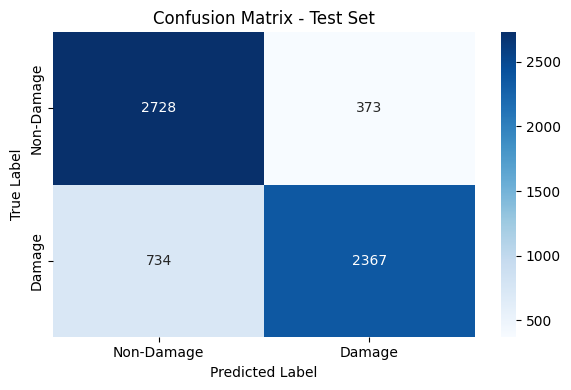

In [28]:
# ========== Imports ==========
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib

# ========== Load Merged Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)

# ========== Preprocess Labels ==========
label_map = {'damage': 1, 'non-damage': 0}
df['Binary_class'] = df['Binary_class'].str.strip().str.lower().map(label_map)

# ========== Handle Missing Text ==========
df['Processed_data'] = df['Processed_data'].fillna("")

# ========== TF-IDF on Full Data ==========
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_full = vectorizer.fit_transform(df['Processed_data']).toarray()
y_full = df['Binary_class'].values

# ========== Apply SMOTE on Full Data ==========
print("Before SMOTE:", np.bincount(y_full))
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_full, y_full)
print("After SMOTE :", np.bincount(y_balanced))

# ========== 80/20 Train-Test Split on Balanced Data ==========
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.20, random_state=42, stratify=y_balanced
)

# ========== Train Random Forest ==========
rf_model = RandomForestClassifier(
    n_estimators=80,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42
)
rf_model.fit(X_train, y_train)

# ========== Save Model and Vectorizer ==========
joblib.dump(rf_model, "/kaggle/working/random_forest_model.joblib")
joblib.dump(vectorizer, "/kaggle/working/tfidf_vectorizer.pkl")

# ========== Evaluate Model ==========
y_test_pred = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]
accuracy_test = accuracy_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_proba)
classification_rep_test = classification_report(y_test, y_test_pred)

print("\n📊 Test Evaluation Summary:")
print(f"✅ Test Accuracy   : {accuracy_test:.4f}")
print(f"✅ Test ROC-AUC    : {roc_auc_test:.4f}")
print("✅ Classification Report:\n", classification_rep_test)

# ========== Confusion Matrix ==========
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Damage', 'Damage'],
            yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()
